# MNIST with CNN

In [1]:
import os
import urllib

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

## Init variables

In [2]:
savefile = "./STORED_model/my_trained_model.json"

### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [3]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [4]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.


In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Create a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 

In [6]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [7]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [8]:
def normal_full_layer(input_layer, size, softact=False):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    if softact:
        return tf.nn.softmax(tf.matmul(input_layer, W) + b)
    else:
        return tf.matmul(input_layer, W) + b
        

# Helper (custom functions)

In [9]:
def one_hot_encode(pos):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    out = np.zeros(10)
    out[pos] = 1
    return out

In [10]:
#duck smile car pencil star burger cookie rabbit moon icecream
fileList = ['smile','car','pencil','burger','moon','hand','tornado','scissors','mug','sock']
for i in range(len(fileList)):
    print('{} lenght {}'.format(fileList[i], len(np.load('./SKETCH_data/'+fileList[i]+'.npy'))))


smile lenght 124386
car lenght 182764
pencil lenght 122001
burger lenght 129672
moon lenght 121661
hand lenght 291773
tornado lenght 143271
scissors lenght 123390
mug lenght 152918
sock lenght 205715


In [11]:
def display(img, label, predict):
    plt.title('Real %s. Predict: %s - %s' % (label, predict, "Correct" if (label==predict) else "No correct" ))
    plt.imshow(img.reshape((28,28)), cmap=plt.cm.gray_r)
    plt.show()
    
# usage: display(test_x[0], 0, 0)

In [12]:
class SketchImageHelper():
    
    def __init__(self):
        print("Init SketchImageHelper")
        self.position = 0
        
        self.batch_x = None
        self.batch_y = None
        
        self.pos_begin = 1000
        self.pos_end = 110000
        
        self.images = []
        self.labels = []
        
        self.fileList = fileList
    
    def set_up_images(self):
        
        print("Setting Up Batch Images and Labels")
        sampleSize = self.pos_end - self.pos_begin
        i = 0
        for i in range(len(self.fileList)):
            partialImages = np.array(np.load('./SKETCH_data/'+ self.fileList[i] +'.npy')[self.pos_begin:self.pos_end])
            self.images.append( partialImages / 255)
            self.labels.append(np.full((sampleSize,10), one_hot_encode(i)))

        print('batch lenght {}'.format(len(self.images)))
        print('batch lenght {}'.format(len(self.labels)))
        
        
    def next_batch(self, batch_size):                          
        x = []
        y = []
        partial_batch = batch_size // len(self.fileList)
        i = 0
        for i in range(len(self.fileList)):
            if i==0:
                x = np.array((self.images[i])[self.position:self.position+partial_batch])
                y = np.array((self.labels[i])[self.position:self.position+partial_batch])
            else:
                x = np.concatenate((x,np.array((self.images[i])[self.position:self.position+partial_batch])), axis=0)
                y = np.concatenate((y,np.array((self.labels[i])[self.position:self.position+partial_batch])), axis=0)  

        
        self.position = (self.position + partial_batch)
        print(' {}'.format(self.position), end='')
        return x, y

In [13]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [14]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

### Layers

In [15]:
x_image = tf.reshape(x,[-1,28,28,1])

In [16]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of 
# a single image.
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [17]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [18]:
# Why 7 by 7 image? Because we did 2 pooling layers, so (28/2)/2 = 7
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [19]:
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [20]:
y_pred = normal_full_layer(full_one_dropout,10,True)

### Loss Function

In [21]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001) # 0.0001
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [23]:
init = tf.global_variables_initializer()

### Session

In [24]:
#duck smile car pencil star burger cookie rabbit moon icecream

pos_begin = 0
pos_end = 500
test_x = np.concatenate((np.array(np.load('./SKETCH_data/smile.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/car.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/pencil.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/burger.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/moon.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/hand.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/tornado.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/scissors.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/mug.npy')[pos_begin:pos_end]),np.array(np.load('./SKETCH_data/sock.npy')[pos_begin:pos_end])), axis=0)
test_y = np.concatenate((np.full((pos_end-pos_begin,10), one_hot_encode(0)), np.full((pos_end-pos_begin,10), one_hot_encode(1)), np.full((pos_end-pos_begin,10), one_hot_encode(2)), np.full((pos_end-pos_begin,10), one_hot_encode(3)),
                               np.full((pos_end-pos_begin,10), one_hot_encode(4)), np.full((pos_end-pos_begin,10), one_hot_encode(5)), np.full((pos_end-pos_begin,10), one_hot_encode(6)), np.full((pos_end-pos_begin,10), one_hot_encode(7)),
                               np.full((pos_end-pos_begin,10), one_hot_encode(8)), np.full((pos_end-pos_begin,10), one_hot_encode(9))), axis=0)

print('test_x lenght {}'.format(len(test_x)))
print('test_y lenght {}'.format(len(test_y)))

test_x lenght 5000
test_y lenght 5000


In [25]:
sih = SketchImageHelper()
sih.set_up_images()
saver = tf.train.Saver()
#sess = tf.InteractiveSession()

Init SketchImageHelper
Setting Up Batch Images and Labels
batch lenght 10
batch lenght 10


In [26]:
with tf.Session() as sess:
    steps = 3000 #1850

    print('INIT')
    sess.run(init)

    for j in range(steps):
        # print('.', end='')
        batch_x , batch_y = sih.next_batch(100) # Batch size -> 64 / 128
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5}) # initial:0.5 Hold prob -> 0.8 aprox

        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if j%50 == 0:
            print('\n')
            print('step {}'.format(j))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:test_x,y_true:test_y,hold_prob:1.0}))


    print('\n')
    print('FINAL Accuracy is:')
    print(sess.run(acc,feed_dict={x:test_x,y_true:test_y,hold_prob:1.0}))
    print('\n')
    
    saver.save(sess, savefile)

INIT
 10

step 0
Accuracy is:
0.1168
 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510

step 50
Accuracy is:
0.304
 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010

step 100
Accuracy is:
0.4342
 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510

step 150
Accuracy is:
0.5092
 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 19

0.7798
 14020 14030 14040 14050 14060 14070 14080 14090 14100 14110 14120 14130 14140 14150 14160 14170 14180 14190 14200 14210 14220 14230 14240 14250 14260 14270 14280 14290 14300 14310 14320 14330 14340 14350 14360 14370 14380 14390 14400 14410 14420 14430 14440 14450 14460 14470 14480 14490 14500 14510

step 1450
Accuracy is:
0.7656
 14520 14530 14540 14550 14560 14570 14580 14590 14600 14610 14620 14630 14640 14650 14660 14670 14680 14690 14700 14710 14720 14730 14740 14750 14760 14770 14780 14790 14800 14810 14820 14830 14840 14850 14860 14870 14880 14890 14900 14910 14920 14930 14940 14950 14960 14970 14980 14990 15000 15010

step 1500
Accuracy is:
0.7626
 15020 15030 15040 15050 15060 15070 15080 15090 15100 15110 15120 15130 15140 15150 15160 15170 15180 15190 15200 15210 15220 15230 15240 15250 15260 15270 15280 15290 15300 15310 15320 15330 15340 15350 15360 15370 15380 15390 15400 15410 15420 15430 15440 15450 15460 15470 15480 15490 15500 15510

step 1550
Accuracy is:
0.79

 26020 26030 26040 26050 26060 26070 26080 26090 26100 26110 26120 26130 26140 26150 26160 26170 26180 26190 26200 26210 26220 26230 26240 26250 26260 26270 26280 26290 26300 26310 26320 26330 26340 26350 26360 26370 26380 26390 26400 26410 26420 26430 26440 26450 26460 26470 26480 26490 26500 26510

step 2650
Accuracy is:
0.8102
 26520 26530 26540 26550 26560 26570 26580 26590 26600 26610 26620 26630 26640 26650 26660 26670 26680 26690 26700 26710 26720 26730 26740 26750 26760 26770 26780 26790 26800 26810 26820 26830 26840 26850 26860 26870 26880 26890 26900 26910 26920 26930 26940 26950 26960 26970 26980 26990 27000 27010

step 2700
Accuracy is:
0.7908
 27020 27030 27040 27050 27060 27070 27080 27090 27100 27110 27120 27130 27140 27150 27160 27170 27180 27190 27200 27210 27220 27230 27240 27250 27260 27270 27280 27290 27300 27310 27320 27330 27340 27350 27360 27370 27380 27390 27400 27410 27420 27430 27440 27450 27460 27470 27480 27490 27500 27510

step 2750
Accuracy is:
0.8122
 275

INFO:tensorflow:Restoring parameters from ./STORED_model/my_trained_model.json


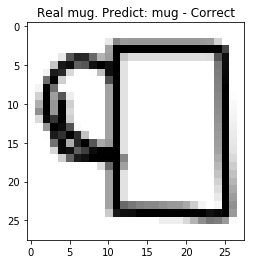

In [39]:
classTypeId = 8 #values between 0..10
imageNumber = 10 #value between 0..500
with tf.Session() as sess:
    # restore the model
    saver.restore(sess, savefile)

    myclass = sih.fileList[classTypeId]
    evalImage = (np.load('./SKETCH_data/{}.npy'.format(myclass))[500 + imageNumber] / 255)

    feed_dict = {x: np.reshape(evalImage,newshape=(1,784)), y_true: np.zeros((1, 10)), hold_prob : 0.5 }

    classification = sess.run(tf.argmax(y_pred,1), feed_dict)

    display(evalImage, myclass, sih.fileList[int(classification)])
        
        

## Great Job!